# ART calculations for `All` virus

In [1]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [2]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [3]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/AllVirus/'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [17]:
AllVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "allVirusData_chEMBL_wMACAW.csv")
AllVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,2,CHEMBL4852507,C=CCn1ccc2c(C(=O)Oc3cncc(Cl)c3)cccc21,4.823909,SARS-CoV-2,0.217738,-0.031447,-0.044342,-0.001320,-0.075413,0.037756,-0.047275,-0.010448,-0.058355,-0.022279,0.005351,-0.088648,-0.149209,0.055279,-0.019730
1,3,CHEMBL4846056,CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CN1CC...,4.997834,SARS-CoV-2,-0.071457,0.037183,-0.126172,0.003091,0.071098,-0.035972,-0.020770,-0.034783,0.006979,0.009339,0.042201,0.044127,-0.032492,-0.026910,0.040156
2,4,CHEMBL5419985,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@@H]2CC...,7.193820,SARS-CoV-2,-0.179532,-0.062806,-0.065860,-0.113641,0.052536,0.039251,-0.121876,-0.169874,-0.006342,0.115027,-0.132802,0.056286,-0.166178,-0.116255,0.102158
3,5,CHEMBL46286,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...,5.677781,SARS-CoV-2,-0.107027,-0.069619,-0.075954,0.044638,0.071964,-0.002109,-0.113495,0.019113,-0.025058,-0.024908,-0.000667,0.076293,0.034652,-0.015838,-0.005553
4,6,CHEMBL4802135,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,7.127844,SARS-CoV-2,-0.164884,-0.096613,-0.039586,-0.141431,0.047791,0.053376,-0.164457,-0.188033,0.016148,0.121460,-0.175393,0.087129,-0.175492,-0.097911,0.111749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4508,14312,CHEMBL5590446,CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1OC(=O)CCCN1CCCCC1,5.337242,Marburg,0.000218,-0.063550,-0.186634,-0.006988,0.061154,-0.022618,-0.073083,-0.058731,0.046577,0.009361,-0.031680,0.037891,-0.019288,-0.107254,-0.007046
4509,14313,CHEMBL5584026,CN1CCN(CC(=O)O[C@H]2C(C)(C)[C@H]3CC[C@]2(C)C3)CC1,4.602060,Marburg,0.024332,-0.070576,-0.166729,-0.013246,0.034427,-0.035536,-0.074907,-0.064229,0.051796,0.022002,-0.038961,0.036861,-0.004770,-0.077544,-0.012340
4510,14314,CHEMBL1631748,O=c1c(/C=N/Cc2ccco2)c(CSc2ccc(Cl)cc2)[nH]n1-c1...,8.886057,Hanta,0.096948,-0.005462,0.034884,0.019025,-0.053357,0.069403,-0.011438,0.065869,-0.031654,0.037337,-0.049204,-0.068065,0.015889,-0.064082,-0.048406
4511,14315,CHEMBL1630982,O=C(NCc1ccc2c(c1)OCO2)C(Cc1ccccc1)NS(=O)(=O)c1...,8.795880,Hanta,-0.011623,0.163591,0.032460,-0.052924,-0.043404,0.060166,0.048506,0.073996,-0.041288,-0.024673,0.009352,-0.011025,0.035367,-0.009648,-0.009404


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [18]:
input_var = [col for col in AllVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [19]:
features = AllVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [20]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [21]:
response = AllVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [9]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'AllVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [10]:
AllVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "AllVirusData_chEMBL_wMACAW_ARTready.csv")
AllVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,0.217738
1,1,MACAW_1,-0.071457
2,2,MACAW_1,-0.179532
3,3,MACAW_1,-0.107027
4,4,MACAW_1,-0.164884
...,...,...,...
72203,4508,pPotency,5.337242
72204,4509,pPotency,4.602060
72205,4510,pPotency,8.886057
72206,4511,pPotency,8.795880


### Define the ART parameters needed for the prediction

In [12]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': False,
    'num_tpot_models': 0,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 4,513 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my


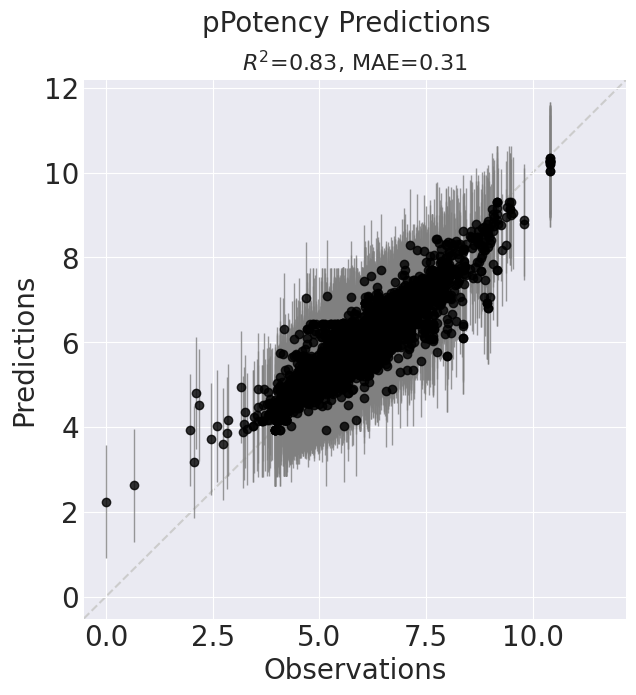

CPU times: user 1h 28min 10s, sys: 7min 31s, total: 1h 35min 42s
Wall time: 1h 36min 5s


In [13]:
%%time

art = RecommendationEngine(df=AllVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [8]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/AllVirus/art.cpkl


### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [9]:
AllVirus_EnamineDatasets_wMACAW = pd.read_csv(resultsDir + "AllVirus/AllVirus_EnamineDataset_wMACAW.csv")
AllVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,0.094941,-0.071844,-0.103945,-0.051427,0.007874,0.041002,-0.009428,-0.037093,0.007164,0.039570,0.009551,0.037751,-0.027897,-0.031289,-0.042986
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,0.077105,-0.008348,-0.152235,-0.056807,0.010467,0.050085,-0.017541,-0.026417,0.021554,0.014786,-0.007979,-0.028799,-0.003459,-0.036435,-0.001529
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,0.063317,0.003488,-0.178812,0.069043,0.037155,0.012006,-0.047026,-0.031709,0.037849,0.075959,0.024293,0.023578,0.033130,-0.015203,-0.013781
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,0.049645,-0.018560,-0.166953,0.014666,0.041300,0.014442,-0.054776,-0.029845,0.019072,0.063057,0.018246,0.026803,0.034515,-0.048720,0.008049
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,0.040965,0.022632,-0.171750,0.010715,0.070113,0.014929,-0.066008,-0.025070,0.029395,0.028263,-0.011735,-0.012817,-0.010866,-0.011482,0.038715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,0.037361,0.038209,-0.181728,-0.014734,0.062582,0.034545,-0.018894,-0.051233,-0.005012,0.069534,0.077748,0.006461,0.015092,-0.007407,0.000456
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,0.142184,-0.065929,-0.086203,-0.100604,-0.003457,0.003118,-0.066869,0.035066,0.039697,0.013334,0.006554,0.005581,-0.031470,0.009457,0.005732
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,0.050549,-0.045993,-0.143790,-0.006099,0.022090,0.011516,-0.016317,-0.008561,0.030805,0.075122,-0.013022,0.009989,0.009981,-0.042674,-0.039633
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,0.067664,-0.020496,-0.181175,0.028068,0.078802,0.029840,-0.033331,0.023221,0.030655,0.068720,0.006219,0.012053,0.048836,-0.020152,-0.006210


In [10]:
macaw_columns = [col for col in AllVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = AllVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [11]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

array([[5.11999071],
       [5.40901279],
       [4.90672598],
       ...,
       [5.07245133],
       [5.24193647],
       [4.83562006]])

Get predictions with uncertainty using ART's post_pred_stats

In [12]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = AllVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,5.119991,0.674573,3.797828,6.442153,0.000008,3.612826e-07,0.000159
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,5.409013,0.674142,4.087694,6.730331,0.000004,1.860668e-07,0.000082
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,4.906726,0.674204,3.585286,6.228166,0.000012,5.913362e-07,0.000260
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,4.879879,0.674231,3.558385,6.201372,0.000013,6.289675e-07,0.000276
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,5.198782,0.674140,3.877469,6.520096,0.000006,3.019287e-07,0.000133
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,5.240053,0.674091,3.918835,6.561272,0.000006,2.746173e-07,0.000121
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,5.835830,0.674224,4.514350,7.157309,0.000001,6.961303e-08,0.000031
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,5.072451,0.674065,3.751284,6.393619,0.000008,4.040000e-07,0.000177
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,5.241936,0.674083,3.920735,6.563138,0.000006,2.734399e-07,0.000120


## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [10]:
AllVirus_LCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "AllVirus/AllVirus_LCAntiviralsData_wMACAW.csv")
AllVirus_LCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,0.061909,0.008082,-0.223399,-0.013159,0.080993,-0.005791,-0.019669,-0.009138,0.055137,0.034627,0.028965,-0.040567,0.027293,-0.074869,-0.023219
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,0.076102,-0.055677,-0.208305,-0.002261,-0.005890,0.003244,-0.032359,0.036268,0.049363,0.052545,-0.070616,-0.005374,-0.014058,-0.038679,0.011488
2,CN1CCCN(Cc2ccncc2)CC1,0.112221,-0.027666,-0.204234,0.053164,0.010586,-0.029933,-0.053492,-0.028870,0.119459,0.028846,-0.033875,-0.044201,0.049615,0.001155,-0.055063
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,0.087564,-0.058219,-0.173996,-0.001765,0.009564,0.002216,-0.054324,0.020327,0.055939,0.068611,-0.033139,0.025484,-0.004313,-0.045328,-0.013246
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,0.086965,-0.051544,-0.187365,-0.006942,0.005175,-0.029640,-0.010013,-0.029627,0.074079,0.065494,0.003269,-0.033878,0.016262,-0.044851,-0.034485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45559,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,0.171333,0.061850,0.017606,0.075083,0.028206,-0.015956,-0.048598,0.014453,0.061743,-0.022265,-0.075810,-0.029207,0.002302,0.028008,-0.006212
45560,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,0.097773,0.040891,-0.052282,0.077892,0.023753,-0.001890,-0.056709,0.009384,0.020920,-0.023235,-0.075997,-0.027909,0.025861,-0.001363,-0.053803
45561,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,0.184494,-0.061907,-0.024151,-0.016798,-0.064467,-0.016044,-0.083255,0.027243,-0.062546,-0.061145,-0.027247,-0.017127,-0.041981,-0.019199,-0.063264
45562,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,-0.034853,0.034738,0.037970,0.091482,-0.039612,0.002518,-0.013001,0.057092,0.003837,-0.008485,-0.051220,-0.019664,0.074874,0.009710,-0.048618


In [11]:
macaw_columns = [col for col in AllVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = AllVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = AllVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [21]:
AllVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(resultsDir + "AllVirus/AllVirus_ChemDivAntiviralsData_wMACAW.csv")
AllVirus_ChemDivAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,0.075330,0.042720,-0.023890,0.039443,0.026468,0.031865,-0.090361,0.043187,-0.004305,-0.004178,0.018925,0.046296,0.047139,0.011930,-0.021202
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,0.026020,0.035905,-0.113773,0.071340,-0.004334,0.009203,-0.074341,-0.000484,0.005409,0.089103,-0.003469,0.000944,0.017610,-0.056614,-0.002357
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,0.056963,0.028106,-0.013658,0.002446,0.043271,0.007476,-0.107889,0.046668,0.002557,-0.007811,0.048891,0.092400,0.082530,0.040292,-0.034692
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,0.094566,0.047991,-0.008333,0.009667,-0.027117,0.080935,-0.048112,0.033606,-0.072464,0.027219,0.010141,0.007348,-0.025606,-0.023325,-0.007293
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,0.031347,0.152461,-0.075195,0.047097,-0.029678,0.013887,-0.039965,0.071459,-0.053949,0.077873,0.052437,-0.026694,0.010359,-0.033992,0.022385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64950,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,-0.016184,-0.016789,0.021458,0.087594,-0.009384,0.059302,-0.023672,0.035847,-0.065487,0.067549,-0.009259,-0.001973,-0.003436,-0.023963,0.002344
64951,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,0.005652,0.012692,0.013652,0.083465,-0.012236,0.067214,0.005746,0.055203,-0.068494,0.057065,-0.017964,0.002311,-0.019255,-0.024034,0.021413
64952,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,0.001354,-0.010339,-0.017095,0.073858,-0.023754,0.046620,-0.021606,0.042544,-0.069193,0.067267,-0.006215,0.021753,-0.022509,-0.021997,0.009254
64953,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,0.061261,-0.056494,0.085588,0.024522,-0.006285,0.046520,-0.038416,0.046554,-0.042279,0.042043,-0.052829,0.011933,0.000242,0.006529,0.024947


In [22]:
macaw_columns = [col for col in AllVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = AllVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = AllVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [13]:
AllVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "AllVirus/AllVirus_SMACCAntiviralsData_wMACAW.csv")
AllVirus_SMACCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,0.138852,-0.026306,-0.072553,-0.081836,-0.070781,0.061373,-0.032593,0.017000,0.007148,0.016383,0.008146,-0.015792,-0.055304,-0.010144,-0.012951
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,0.126053,0.053956,0.016432,-0.042802,-0.070733,-0.009141,0.025690,0.057972,-0.041732,-0.101031,-0.035195,-0.043276,-0.030361,-0.042968,-0.006182
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,0.127381,-0.046269,-0.070509,-0.029635,-0.102128,0.032683,-0.044423,0.016246,-0.038657,-0.015216,0.005782,-0.012958,-0.020256,-0.042120,-0.049874
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,0.158347,-0.059789,-0.170574,-0.028771,-0.118354,0.008098,-0.004999,-0.058808,0.006333,-0.053675,-0.012764,-0.025338,-0.015329,-0.007457,-0.017310
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,0.069150,0.067947,-0.000440,-0.044330,-0.124012,0.008729,-0.023626,0.083059,0.013274,-0.023124,-0.055075,0.006242,-0.030724,-0.023504,0.013116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,S=C1NN=C(Nc2ccccc2)S1,0.176288,-0.095982,-0.098272,-0.025072,-0.062776,0.039954,0.028945,-0.069647,0.037523,0.002492,0.038048,0.006674,-0.042997,-0.036905,-0.019402
1598,S=C1Nc2ccccc2S1,0.156049,-0.092120,-0.136473,-0.022302,-0.070159,0.019375,0.031209,-0.071835,0.044861,-0.006207,0.006080,-0.005677,0.007268,-0.041230,-0.032816
1599,SC(=S)N1CCCC1,0.075963,-0.077680,-0.154480,-0.013752,-0.020833,-0.020113,-0.019660,-0.014916,0.050530,-0.006364,-0.036776,-0.007105,0.001431,-0.051606,-0.025810
1600,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,0.212062,-0.077449,-0.077826,0.013608,-0.109700,-0.008008,-0.002226,-0.063723,-0.006470,-0.001954,-0.016152,-0.049824,-0.026782,-0.036936,-0.049162


In [14]:
macaw_columns = [col for col in AllVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = AllVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [15]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.55214496],
       [6.02811775],
       [5.41608544],
       ...,
       [5.64935443],
       [5.32909715],
       [5.70552057]])

Get predictions with uncertainty using ART's post_pred_stats

In [16]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = AllVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,5.552145,0.674241,4.230633,6.873657,2.804497e-06,1.337651e-07,0.000059
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,6.028118,0.674760,4.705589,7.350647,9.373078e-07,4.460187e-08,0.000020
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,5.416085,0.674138,4.094775,6.737396,3.836318e-06,1.830645e-07,0.000080
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,5.407443,0.674291,4.085832,6.729053,3.913427e-06,1.866152e-07,0.000082
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,5.466777,0.674132,4.145478,6.788075,3.413685e-06,1.629014e-07,0.000072
...,...,...,...,...,...,...,...,...
1597,S=C1NN=C(Nc2ccccc2)S1,5.408329,0.674167,4.086961,6.729697,3.905452e-06,1.863387e-07,0.000082
1598,S=C1Nc2ccccc2S1,5.647633,0.674586,4.325445,6.969821,2.250957e-06,1.071962e-07,0.000047
1599,SC(=S)N1CCCC1,5.649354,0.674503,4.327328,6.971380,2.242051e-06,1.068119e-07,0.000047
1600,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,5.329097,0.674088,4.007884,6.650310,4.687085e-06,2.237121e-07,0.000098


### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [17]:
AllVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(resultsDir + "AllVirus/AllVirus_DTRA_smiles_wMACAW.csv")
AllVirus_DTRA_target_antivirals_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,-0.164373,-0.156656,0.050478,-0.035151,0.071741,0.039691,0.049532,0.091976,-0.034860,0.022119,-0.033720,-0.005915,0.074269,0.236279,0.140464
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,0.063299,-0.135021,-0.085593,-0.143011,0.102670,-0.029187,0.049999,0.075580,0.021982,0.028319,-0.022493,0.047145,0.001084,0.000945,-0.010067


In [18]:
macaw_columns = [col for col in AllVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = AllVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [19]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

array([[6.46535245],
       [5.39942622]])

Get predictions with uncertainty using ART's post_pred_stats

In [20]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = AllVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "AllVirus/AllVirus_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,6.465352,0.674061,5.144193,7.786512,3.424897e-07,1.634888e-08,0.000007
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,5.399426,0.674059,4.078271,6.720581,3.986335e-06,1.902912e-07,0.000084


### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [ ]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES